# **Visualización de Árboles GO para Proteínas Moonlighting**
Este notebook describe cómo utilizar la biblioteca GOATools para extraer identificadores GO y visualizar árboles GO para proteínas moonlighting.


## Montaje de Google Drive y preparación del entorno

Montamos Google Drive para acceder a los archivos almacenados e instalamos GOATools, una herramienta esencial para trabajar con la ontología génica.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install goatools
!wget http://purl.obolibrary.org/obo/go/go-basic.obo -O go-basic.obo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=644ae3b3000a5b1567ae8f8683a355451644f32999054423ae70fa534e554e54
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
--2024-05-07 04:03:35--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 172.64.150.197, 104.18.37.59, 2606:4700:4400::ac40:96c5, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|172.64.150.197|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-05-07 04:03:36--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneonto

## Carga de datos y herramientas
Importamos las bibliotecas necesarias. Cargamos la ontología GO y los datos de las proteínas desde el dataset previamente preparado.

In [ ]:
import pandas as pd
from goatools.obo_parser import GODag

godag = GODag("go-basic.obo")
moon_dataset = pd.read_csv("/content/drive/My Drive/moon_dataset.csv")

go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms


## Extracción de identificadores GO
Definimos una función para extraer y limpiar los identificadores GO listados en las columnas 'GO CC Terms', 'GO BP Terms', y 'GO MF Terms', para posteriormente analizarlos

In [ ]:
def extract_go_ids(go_string):
  """
  Extrae identificadores GO de una cadena de texto que contiene términos GO.
  """
  # Verificamos si la entrada es una cadena y extrae los identificadores GO.
  if isinstance(go_string, str):
    return [part.split(' - ')[0] for part in go_string.split('; ')]
  else:
    return []

# Aplicamos la función a las columnas relevantes para obtener los IDs limpios.
moon_dataset['GO BP IDs'] = moon_dataset['GO BP Terms'].apply(extract_go_ids)
moon_dataset['GO CC IDs'] = moon_dataset['GO CC Terms'].apply(extract_go_ids)
moon_dataset['GO MF IDs'] = moon_dataset['GO MF Terms'].apply(extract_go_ids)

# Visualizamos los resultados para verificar la correcta extracción de los
# identificadores GO.
print(moon_dataset[['GO CC Terms', 'GO CC IDs']].head())

                                         GO CC Terms  \
0  GO:0005604 - basement membrane; GO:0000785 - c...   
1                    GO:0009570 - chloroplast stroma   
2  GO:0035578 - azurophil granule lumen; GO:00057...   
3  GO:0060170 - ciliary membrane; GO:0005829 - cy...   
4  GO:0009986 - cell surface; GO:0005905 - clathr...   

                                           GO CC IDs  
0  [GO:0005604, GO:0000785, GO:0000775, GO:000827...  
1                                       [GO:0009570]  
2  [GO:0035578, GO:0005737, GO:0005829, GO:007006...  
3  [GO:0060170, GO:0005829, GO:0005615, GO:004320...  
4  [GO:0009986, GO:0005905, GO:0030135, GO:000573...  


## Generación de Árboles GO
Implementamos una función para dibujar y visualizar los árboles GO. Estos árboles nos permiten entender mejor la relación entre los términos GO asociados a una proteína.

In [ ]:
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.gosubdag.plot.gosubdag_plot import GoSubDagPlot
from IPython.display import Image, display

def plot_gos(fout_img, goids, go2obj):
    """
    Función que genera visualizaciones de árboles GO a partir de un conjunto de IDs de GO,
    utilizando el objeto de ontología GO proporcionado.
    """
    gosubdag = GoSubDag(goids, go2obj, rcntobj=True)
    godagplot = GoSubDagPlot(gosubdag)
    godagplot.plt_dag(fout_img)
    return fout_img  # Retornará ruta del archivo de imagen generado.

Aplicamos la función para generar visualizaciones de árboles GO para todas las entradas del conjunto de datos y guardamos las imágenes.


In [ ]:
# Diccionarios para almacenar las rutas de las imágenes de árboles GO por
# categoría.
bp_trees, cc_trees, mf_trees = {}, {}, {}

# Iteramos sobre cada registro en el conjunto de datos para procesar los
# términos GO.
for index, row in moon_dataset.iterrows():
    protein_name = row['UniProt IDs']

    # Procesamoslos términos GO por cada categoría: BP, CC y MF.
    for go_domain, go_ids in [('BP', row['GO BP IDs']), ('CC', row['GO CC IDs']), ('MF', row['GO MF IDs'])]:
        if go_ids:
            fout_img = f"{protein_name}_{go_domain}.png"
            img_path = plot_gos(fout_img, go_ids, godag)

            # Almacenamos las rutas de la imágenes en los diccionarios
            # correspondiente.
            if go_domain == 'BP':
                bp_trees[protein_name] = img_path
            elif go_domain == 'CC':
                cc_trees[protein_name] = img_path
            else:  # 'MF'
                mf_trees[protein_name] = img_path

Se han truncado las últimas 5000 líneas del flujo de salida.
 GoSubDag: relationships: set()
    3 usr   7 GOs  WROTE: Q9H307_MF.png
 GoSubDag:   8 sources in 151 GOs rcnt(True). 0 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()
    8 usr 151 GOs  WROTE: P14618_BP.png
 GoSubDag:  13 sources in  31 GOs rcnt(True). 0 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()
   13 usr  31 GOs  WROTE: P14618_CC.png
 GoSubDag:  12 sources in  53 GOs rcnt(True). 0 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()
   12 usr  53 GOs  WROTE: P14618_MF.png
 GoSubDag:   3 sources in  19 GOs rcnt(True). 0 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()
    3 usr  19 GOs  WROTE: Q12629_MF.png
 GoSubDag:   1 sources in   3 GOs rcnt(True). 0 alt GO IDs


Visualizamos los árboles GO correspondientes a la primera proteína de nuestro conjunto.

Árbol GO BP para Q9CW03:


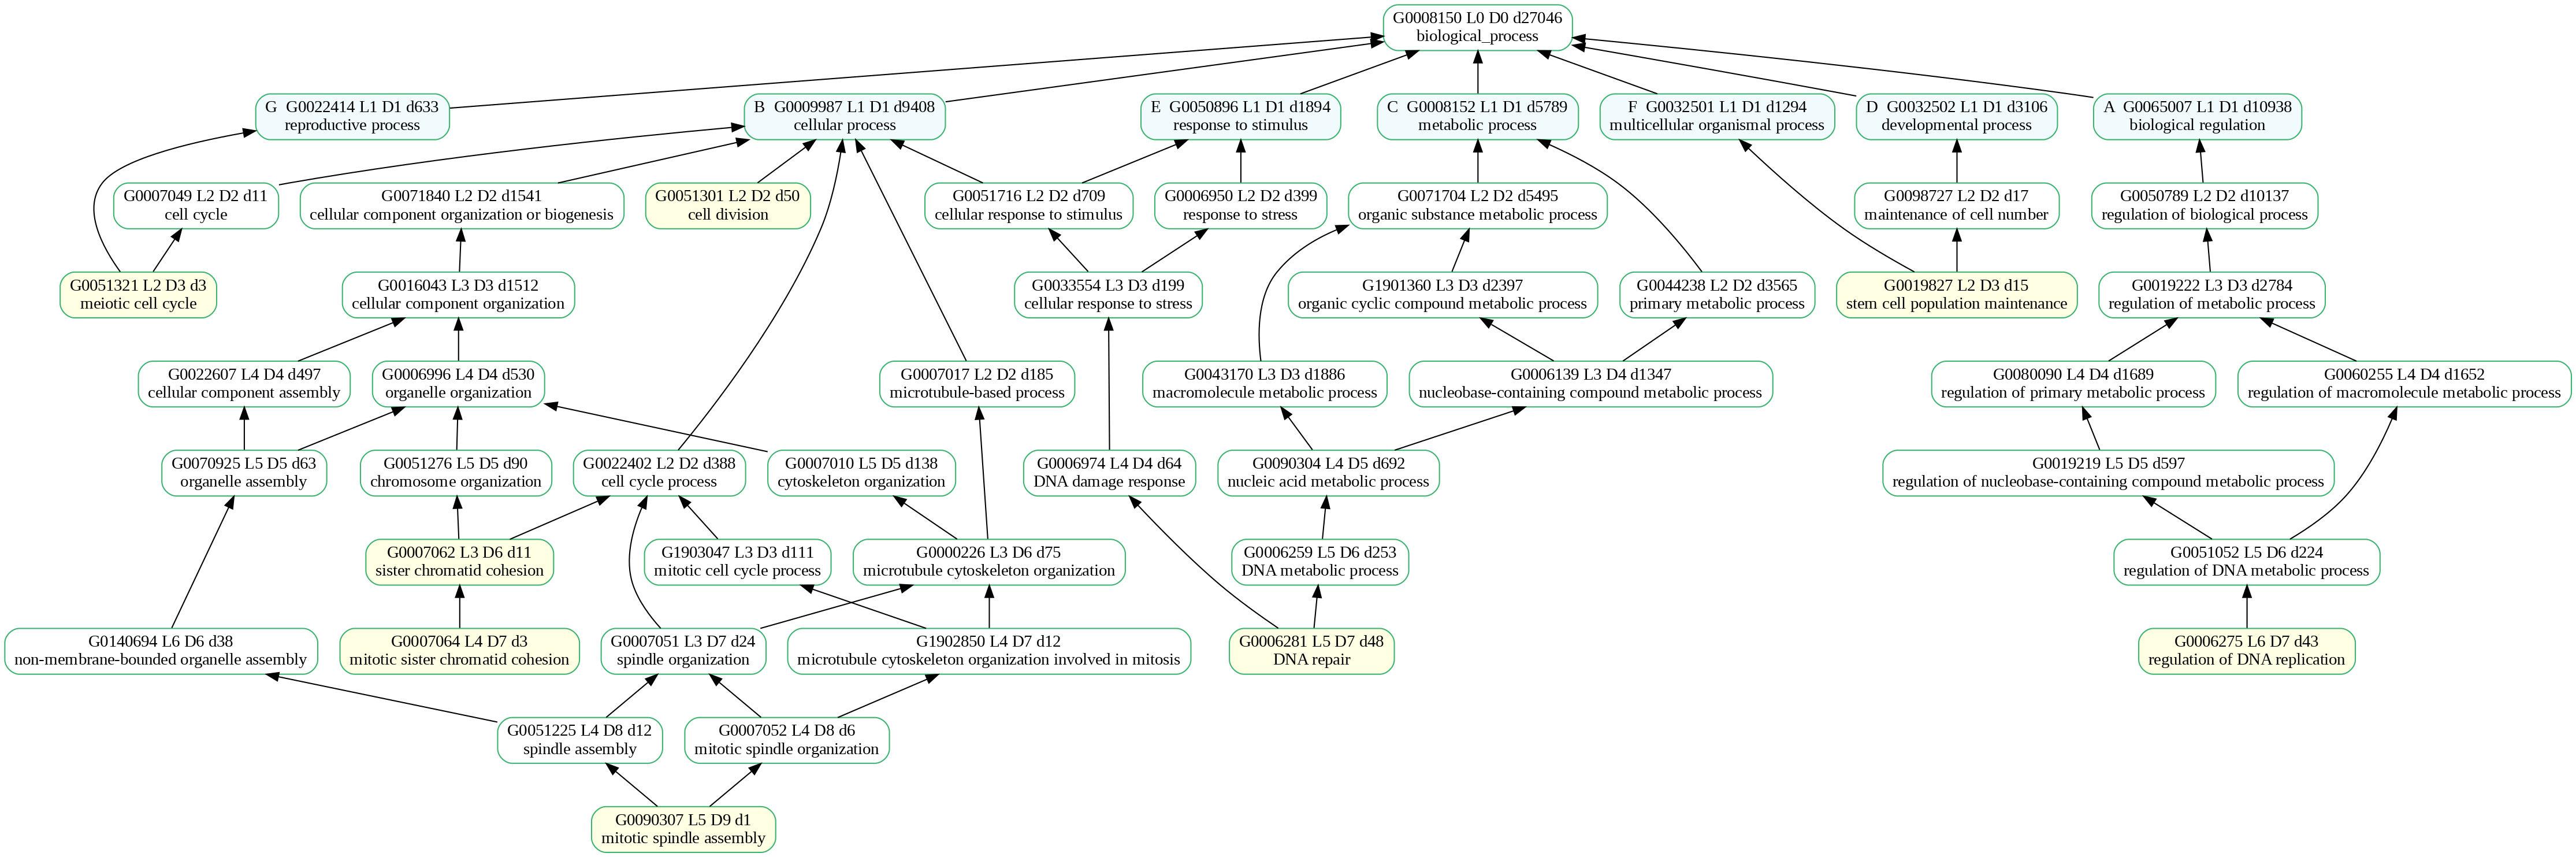

Árbol GO CC para Q9CW03:


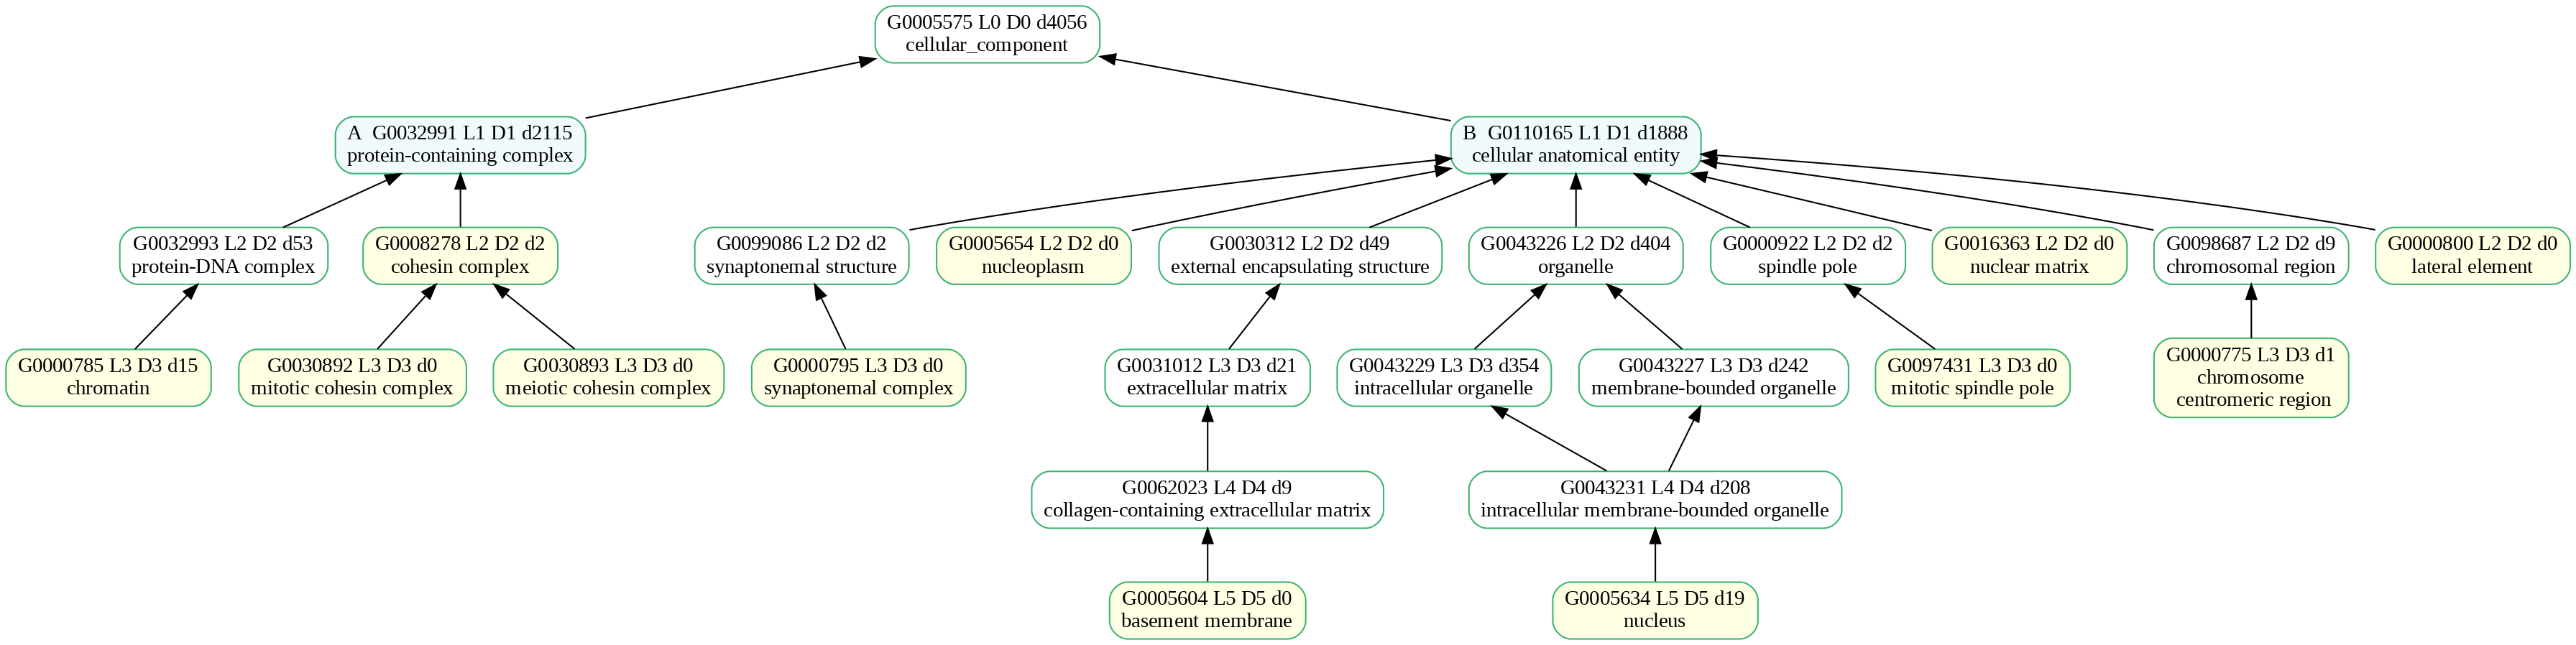

Árbol GO MF para Q9CW03:


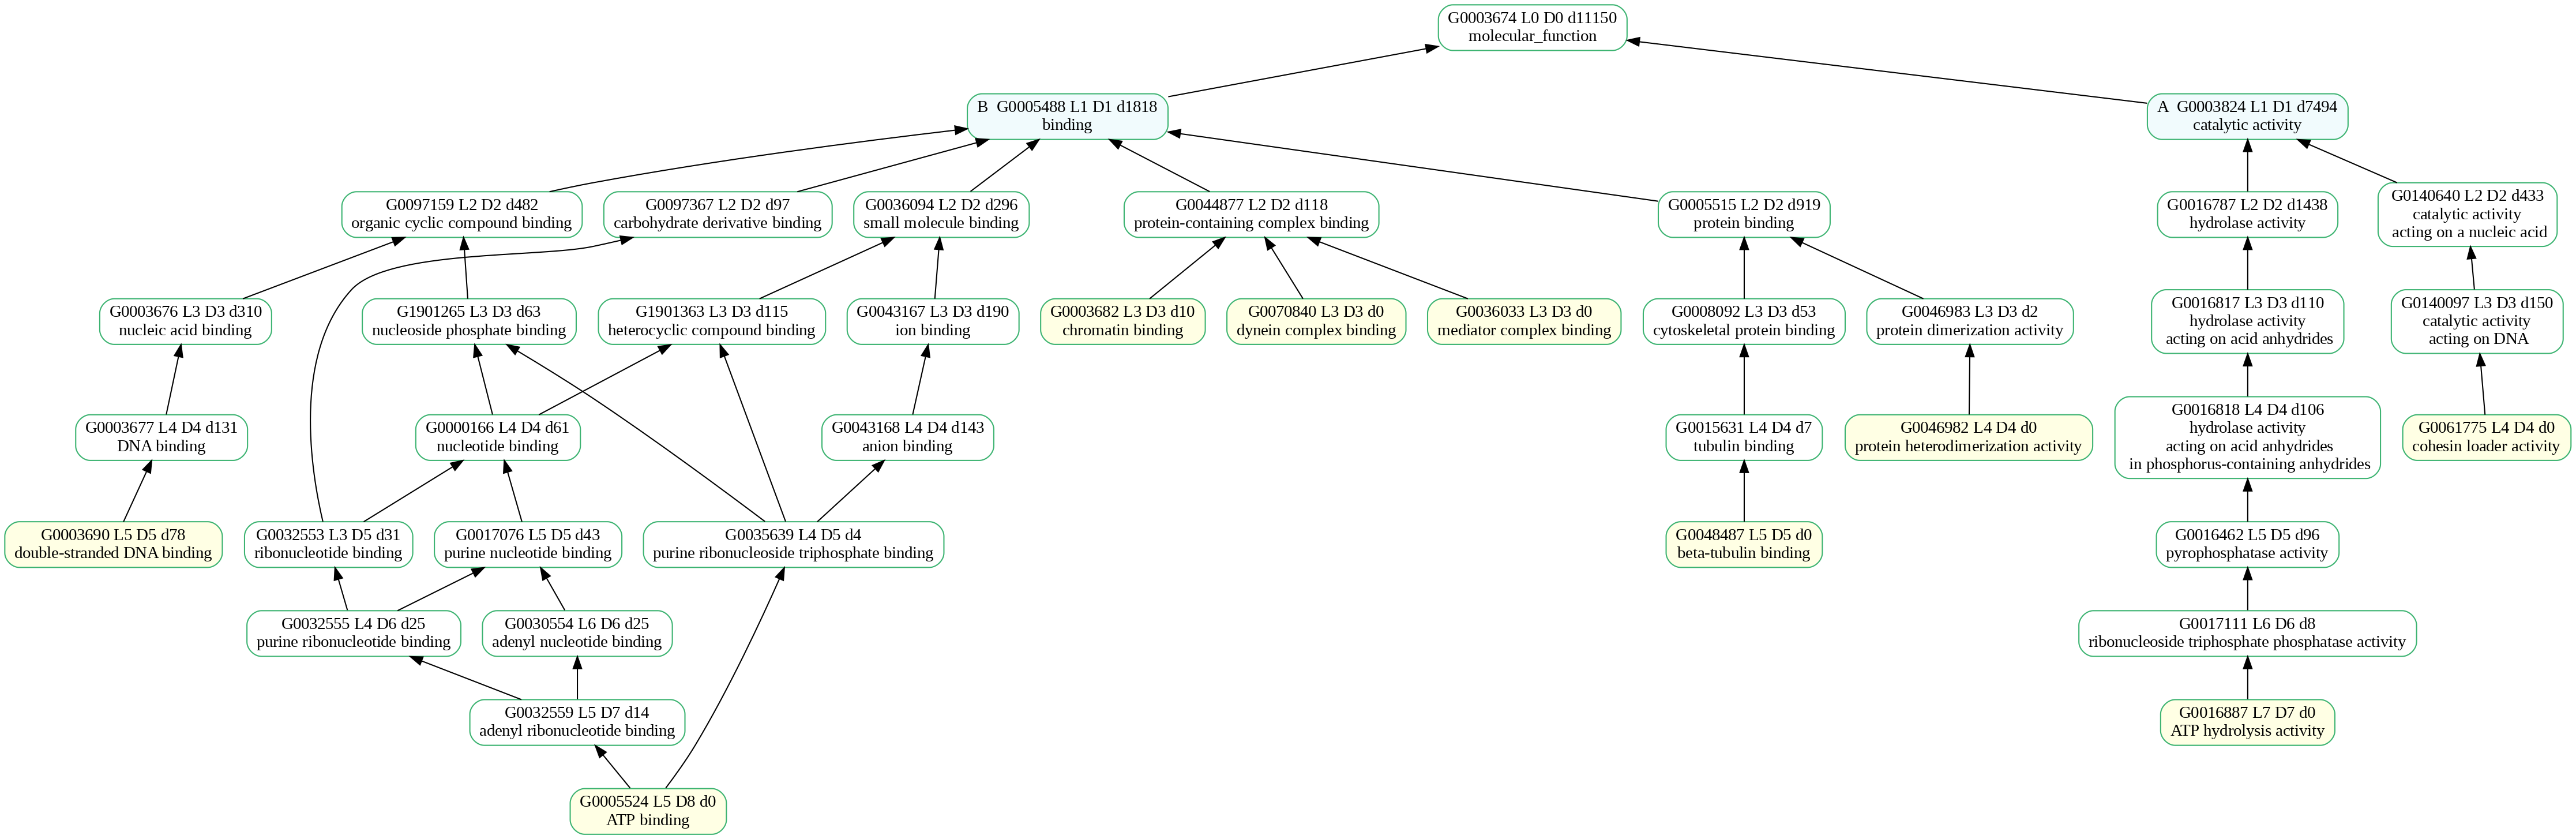

In [ ]:
# Obtenemos el identificador UniProt de la primera proteína en el conjunto de
# datos.
protein_name = moon_dataset.iloc[0]['UniProt IDs']

# Creamos las rutas a los archivos de imagen para las visualizaciones de los
# árboles GO, utilizando el ID de UniProt y clasificando por las diferentes
# categorías de GO.
bp_img_path = bp_trees.get(protein_name, "")
cc_img_path = cc_trees.get(protein_name, "")
mf_img_path = mf_trees.get(protein_name, "")

# Visualizamos los árboles GO.
if bp_img_path:
    print(f"Árbol GO BP para {protein_name}:")
    display(Image(filename=bp_img_path))
if cc_img_path:
    print(f"Árbol GO CC para {protein_name}:")
    display(Image(filename=cc_img_path))
if mf_img_path:
    print(f"Árbol GO MF para {protein_name}:")
    display(Image(filename=mf_img_path))

## Almacenamiento
Finalmente, organizamos las imágenes generadas y compilamos un informe en formato PDF que incluye los árboles GO de cada proteína, asegurando un acceso fácil y estructurado para futuras consultas o presentaciones.


In [ ]:
import os
import shutil

# Creamos un directorio en Google Drive para almacenar las imágenes de los árboles GO.
dest_dir = '/content/drive/My Drive/Proteins_GO_Trees'
os.makedirs(dest_dir, exist_ok=True)

def copy_images_to_drive(trees_dict, domain):
    """
    Función para copiar imágenes de árboles GO al directorio de Google Drive.
    """
    domain_dir = os.path.join(dest_dir, domain)
    os.makedirs(domain_dir, exist_ok=True)
    for protein, img_path in trees_dict.items():
        shutil.copy(img_path, domain_dir)

# Aplicamos la función y clas imágenes de los árboles GO a su respectivo
# directorio en Google Drive.
copy_images_to_drive(bp_trees, 'GO_BP')
copy_images_to_drive(cc_trees, 'GO_CC')
copy_images_to_drive(mf_trees, 'GO_MF')

In [ ]:
# Instalamos ReportLab para la creación de documentos PDF.
!pip install reportlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.8 MB/s eta 0:00:00


In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

def compile_all_domain_images_to_pdf():
    """
    Compila imágenes de árboles GO de diferentes categorías (BP, CC, MF) en un
    documento PDF para cada proteína.
    """
    all_domain_dir = os.path.join(dest_dir, 'All_Domains_PDFs')
    os.makedirs(all_domain_dir, exist_ok=True)

    for protein in set(bp_trees.keys()) | set(cc_trees.keys()) | set(mf_trees.keys()):
        pdf_path = os.path.join(all_domain_dir, f"{protein}_all_domains.pdf")
        c = canvas.Canvas(pdf_path, pagesize=letter)
        width, height = letter

        y_position = height - 20  # Iniciar desde la parte superior de la página.
        image_height = 180  # Altura para las imágenes.
        gap = 20  # Espacio entre imágenes.

        # Añadimos cada imagen de árbol GO al PDF, etiquetandola por su categoría.
        domains = [('BP', 'Biological Process'), ('CC', 'Cellular Component'), ('MF', 'Molecular Function')]
        for domain, label in domains:
            trees_dict = globals().get(f"{domain.lower()}_trees")
            if not trees_dict: continue  # Si el diccionario no existe, continúa con el siguiente.

            img_path = trees_dict.get(protein)
            # Crea una nueva página si no hay suficiente espacio.
            if y_position < (image_height + gap * 3):
                c.showPage()
                y_position = height - 20

            if img_path:
                # Añade la clase y  la imagen.
                c.drawString(72, y_position - 15, f"{label} ({domain}):")
                c.drawImage(ImageReader(img_path), 72, y_position - (image_height + 15), width=400, height=image_height, preserveAspectRatio=True)
                y_position -= (image_height + gap + 40)

            else:
                # Indica si no hay imagen disponible.
                c.drawString(72, y_position - 15, f"{label} ({domain}): No image available")
                y_position -= (gap + 40)

        c.save()
        print(f"PDF generado para {protein} en: {pdf_path}")

compile_all_domain_images_to_pdf()


PDF generado para P06367 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P06367_all_domains.pdf
PDF generado para P04792 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P04792_all_domains.pdf
PDF generado para P62799 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P62799_all_domains.pdf
PDF generado para Q8N165 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/Q8N165_all_domains.pdf
PDF generado para Q383B2 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/Q383B2_all_domains.pdf
PDF generado para P38398 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P38398_all_domains.pdf
PDF generado para P62993 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P62993_all_domains.pdf
PDF generado para P24058 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P24058_all_domains.pdf
PDF generado para P80188 en: /content/drive/My Drive/Proteins_GO_Trees/All_Domains_PDFs/P80188_all_domains.pdf
P